# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar dependencias
Para esta tarea, se han agregado algunos requerimientos, asegúrese de instalarlos (puede usar el mismo entorno virtual de la Tarea 1):

In [1]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA

## Conexión a la Base y Lectura de Datos

In [2]:
# DataFrame con todas las obras:
df_works = pd.read_csv('../data/shakespeare/works.csv')

# Todos los párrafos de todas las obras
df_paragraphs = pd.read_csv('../data/shakespeare/paragraphs.csv')

# TODO: cargar el resto de las tablas
df_chapters = pd.read_csv('../data/shakespeare/chapters.csv')
df_characters = pd.read_csv('../data/shakespeare/characters.csv')

In [3]:
df_paragraphs

,Unnamed: 0,id,ParagraphNum,PlainText,character_id,chapter_id
0,0,630863,3,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",1261,18704
1,1,630864,4,"If music be the food of love, play on;\r\nGive...",840,18704
2,2,630865,19,"Will you go hunt, my lord?",297,18704
3,3,630866,20,"What, Curio?",840,18704
4,4,630867,21,The hart.,297,18704
...,...,...,...,...,...,...
35460,35460,666323,3460,"That she is living,\r\nWere it but told you, s...",866,19648
35461,35461,666324,3467,"You gods, look down\r\nAnd from your sacred vi...",584,19648
35462,35462,666325,3475,There's time enough for that;\r\nLest they des...,866,19648
35463,35463,666326,3483,"O, peace, Paulina!\r\nThou shouldst a husband ...",667,19648


## Limpieza de Texto

In [4]:
# TODO: Actualizar con su versión de clean_text() de la Tarea_1

def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # Quitar signos de puntuación y cambiarlos por espacios (" ")
    for punc in ["[", "]", "\n", "\r", ",", ";", "?", ".", "!", ":", "'", "-", "_", "(", ")", "&", '"', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")


In [5]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Antony", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much,Cleopatra,Antony and Cleopatra,Tragedy
2059,there s beggary in the love that can be reckon d,Antony,Antony and Cleopatra,Tragedy
2060,i ll set a bourn how far to be beloved,Cleopatra,Antony and Cleopatra,Tragedy
2061,then must thou needs find out new heaven new ...,Antony,Antony and Cleopatra,Tragedy
2064,grates me the sum,Antony,Antony and Cleopatra,Tragedy
...,...,...,...,...
27583,thou hadst a clarence too and richard kill d ...,Queen Margaret,Richard III,History
27585,bear with me i am hungry for revenge and no...,Queen Margaret,Richard III,History
27587,i call d thee then vain flourish of my fortune...,Queen Margaret,Richard III,History
27589,forbear to sleep the nights and fast the days...,Queen Margaret,Richard III,History


In [6]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

CharName
Antony            253
Cleopatra         204
Queen Margaret    169
Name: count, dtype: int64

## Dataset y Features de texto

In [7]:
X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

In [8]:
# TODO: Partir train/test 30% estratificados
# -> Definir X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8, stratify = y)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

Tamaños de Train/Test: 438/188


In [9]:
type(y_train)

numpy.ndarray

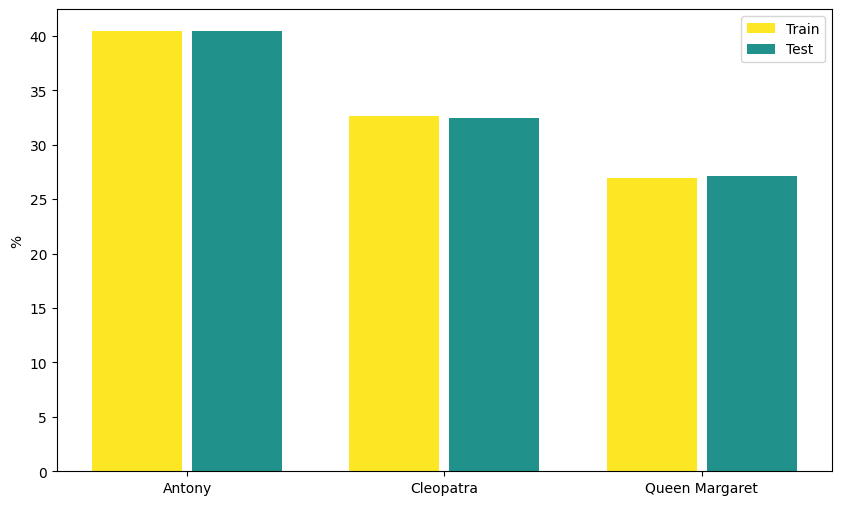

In [10]:
# Visualización para verificar la estratificación
train_parrafos = np.array([(y_train == character).sum() for character in characters])
test_parrafos = np.array([(y_test == character).sum() for character in characters])

porcentaje_train = (train_parrafos / train_parrafos.sum()) * 100
porcentaje_test = (test_parrafos / test_parrafos.sum()) * 100

fig, ax = plt.subplots(figsize=(10, 6))
labels = characters
x = np.arange(len(labels))
width = 0.35

ax.bar(x - 5*width/9, porcentaje_train, width, label='Train', color = '#fde725')
ax.bar(x + 5*width/9, porcentaje_test, width, label='Test', color = '#21918c')

ax.set_ylabel('%')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

### Conteo de palabras y TF-IDF

In [11]:
count_vect_none_11 = CountVectorizer(stop_words=None, ngram_range=(1,1))
X_train_counts_none_11 = count_vect_none_11.fit_transform(X_train)

In [12]:
count_vect_english_11 = CountVectorizer(stop_words='english', ngram_range=(1,1))
X_train_counts_english_11 = count_vect_english_11.fit_transform(X_train)

In [13]:
count_vect_none_12 = CountVectorizer(stop_words=None, ngram_range=(1,2))
X_train_counts_none_12 = count_vect_none_12.fit_transform(X_train)

In [14]:
count_vect_english_12 = CountVectorizer(stop_words='english', ngram_range=(1,2))
X_train_counts_english_12 = count_vect_english_12.fit_transform(X_train)

In [15]:
tf_idf_false = TfidfTransformer(use_idf=False)
X_train_tf_false_none_11 = tf_idf_false.fit_transform(X_train_counts_none_11)
X_train_tf_false_english_11 = tf_idf_false.fit_transform(X_train_counts_english_11)
X_train_tf_false_none_12 = tf_idf_false.fit_transform(X_train_counts_none_12)
X_train_tf_false_english_12 = tf_idf_false.fit_transform(X_train_counts_english_12)

tf_idf_true = TfidfTransformer(use_idf=True)
X_train_tf_true_none_11 = tf_idf_true.fit_transform(X_train_counts_none_11)
X_train_tf_true_english_11 = tf_idf_true.fit_transform(X_train_counts_english_11)
X_train_tf_true_none_12 = tf_idf_true.fit_transform(X_train_counts_none_12)
X_train_tf_true_english_12 = tf_idf_true.fit_transform(X_train_counts_english_12)

In [16]:
X_train_tf_true_english_12

<438x8510 sparse matrix of type '<class 'numpy.float64'>'
	with 12174 stored elements in Compressed Sparse Row format>

### Reducción de dimensionalidad

In [17]:
# TODO: Realizar PCA sobre los datos de entrenamiento
reductor = PCA(n_components=2)

# Transformar train
X_train_red_false_none_11 = reductor.fit_transform(X_train_tf_false_none_11.toarray())
X_train_red_false_english_11 = reductor.fit_transform(X_train_tf_false_english_11.toarray())
X_train_red_false_none_12 = reductor.fit_transform(X_train_tf_false_none_12.toarray())
X_train_red_false_english_12 = reductor.fit_transform(X_train_tf_false_english_12.toarray())
X_train_red_true_none_11 = reductor.fit_transform(X_train_tf_true_none_11.toarray())
X_train_red_true_english_11 = reductor.fit_transform(X_train_tf_true_english_11.toarray())
X_train_red_true_none_12 = reductor.fit_transform(X_train_tf_true_none_12.toarray())
X_train_red_true_english_12 = reductor.fit_transform(X_train_tf_true_english_12.toarray())

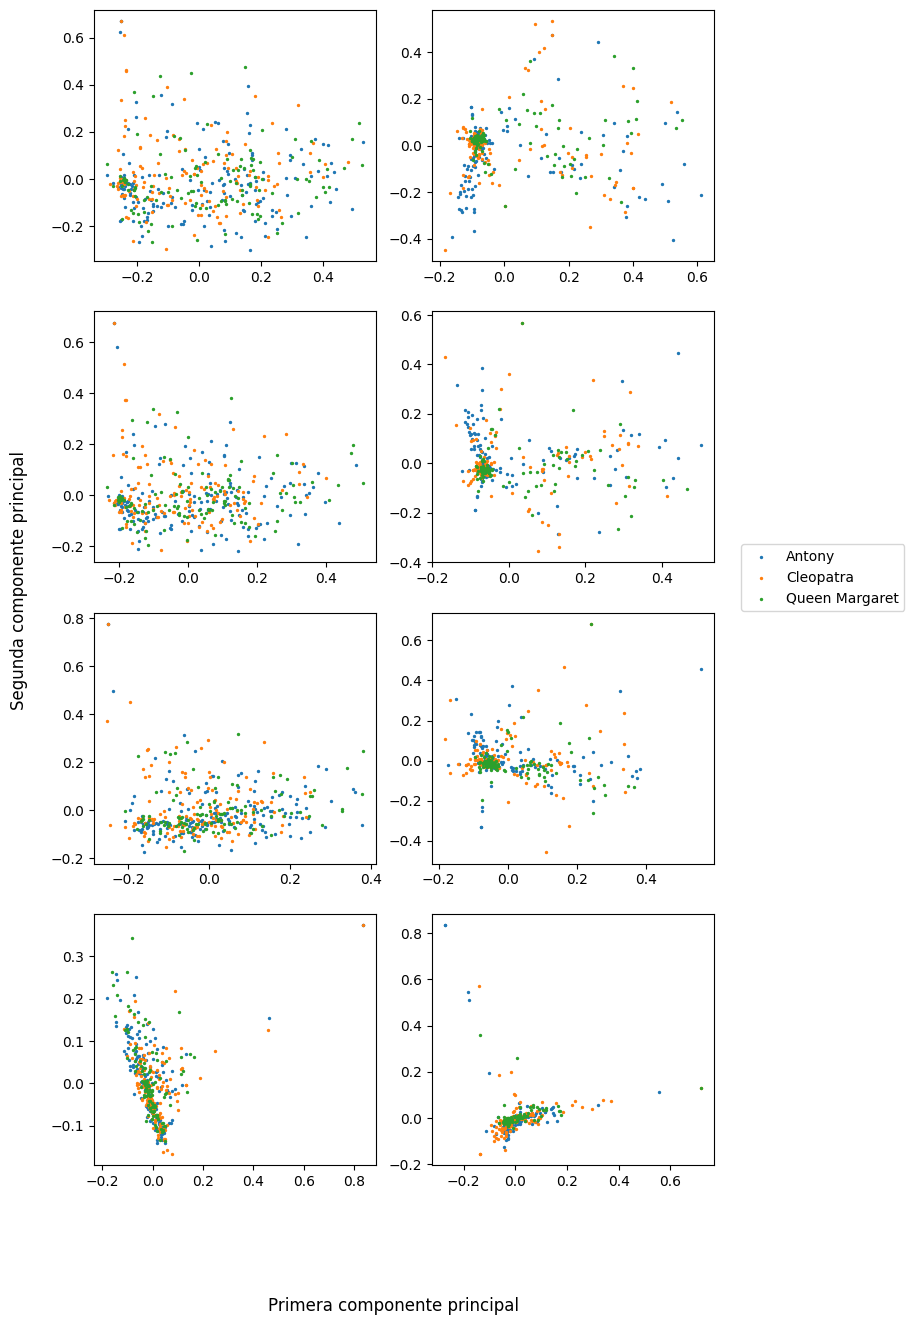

In [18]:
# Visualización de las dos primeras componentes de PCA

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize=(8, 15))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax[0,0].scatter(X_train_red_false_none_11[mask_train, 0], X_train_red_false_none_11[mask_train, 1], s = 2, label=character, )
    ax[0,1].scatter(X_train_red_false_english_11[mask_train, 0], X_train_red_false_english_11[mask_train, 1], s = 2, label=character)
    ax[1,0].scatter(X_train_red_false_none_12[mask_train, 0], X_train_red_false_none_12[mask_train, 1], s = 2, label=character)
    ax[1,1].scatter(X_train_red_false_english_12[mask_train, 0], X_train_red_false_english_12[mask_train, 1], s = 2, label=character)
    ax[2,0].scatter(X_train_red_true_none_11[mask_train, 0], X_train_red_true_none_11[mask_train, 1], s = 2, label=character)
    ax[2,1].scatter(X_train_red_true_english_11[mask_train, 0], X_train_red_true_english_11[mask_train, 1], s = 2, label=character)
    ax[3,0].scatter(X_train_red_true_none_12[mask_train, 0], X_train_red_true_none_12[mask_train, 1], s = 2, label=character)
    ax[3,1].scatter(X_train_red_true_english_12[mask_train, 0], X_train_red_true_english_12[mask_train, 1], s = 2, label=character)

fig.supxlabel('Primera componente principal')
fig.supylabel('Segunda componente principal')
plt.legend(loc='upper right', bbox_to_anchor=(1.7,2.5))
plt.show()


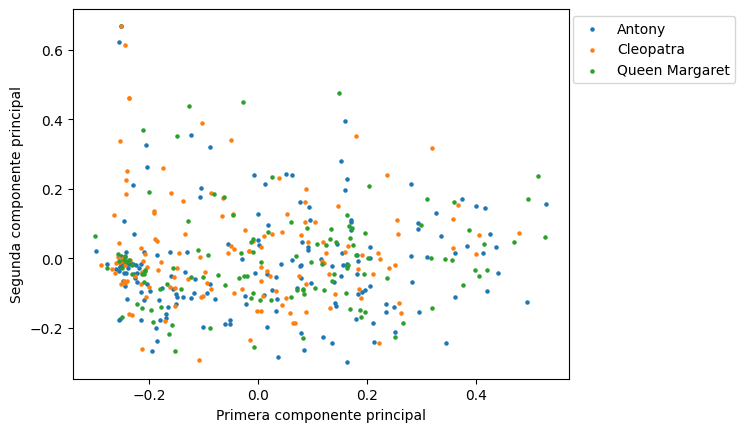

In [19]:
for character in np.unique(y_train):
    mask_train = y_train == character
    plt.scatter(X_train_red_false_none_11[mask_train, 0], X_train_red_false_none_11[mask_train, 1], s = 5, label=character)

plt.xlabel('Primera componente principal')
plt.ylabel('Segunda componente principal')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

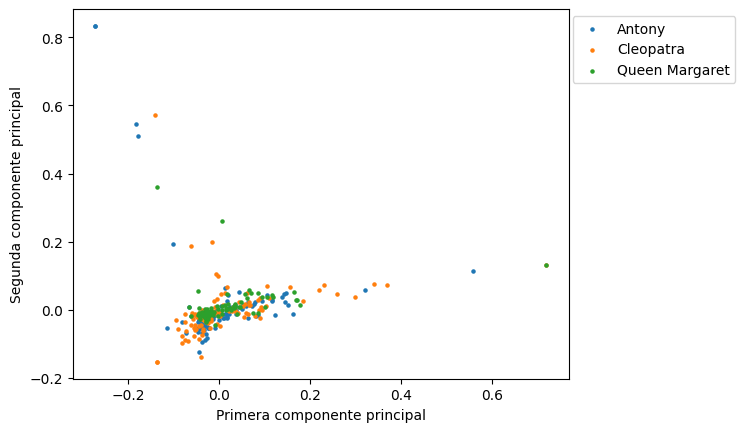

In [20]:
for character in np.unique(y_train):
    mask_train = y_train == character
    plt.scatter(X_train_red_true_english_12[mask_train, 0], X_train_red_true_english_12[mask_train, 1], s = 5, label=character)

plt.xlabel('Primera componente principal')
plt.ylabel('Segunda componente principal')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

In [21]:
# TODO: Realizar PCA sobre los datos de entrenamiento
reductor2 = PCA(n_components=10)

# Transformar train
X_train_red_true_english_12 = reductor2.fit_transform(X_train_tf_true_english_12.toarray())
explained_variance = reductor2.explained_variance_ratio_.round(4)
explained_variance
cum_explained_variance = explained_variance.cumsum()
x_range = range(1,11)

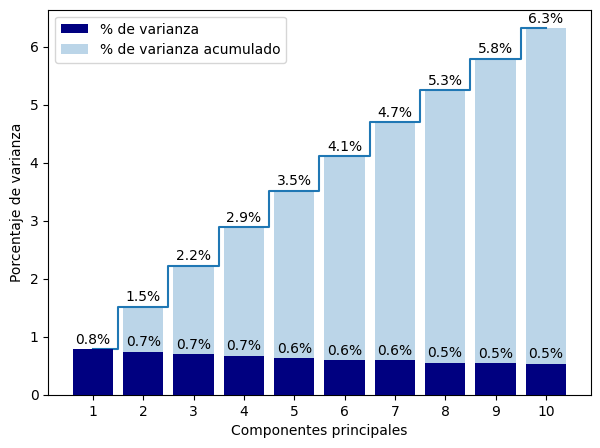

In [22]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.bar(x = x_range, height = explained_variance*100, zorder = 20,
       color = "navy", label = "% de varianza")
ax.bar(x = x_range, height = cum_explained_variance*100, alpha = 0.3,
       label = "% de varianza acumulado")
ax.step(x = x_range, y = cum_explained_variance*100, where = "mid")
ax.set_xlabel("Componentes principales")
ax.set_ylabel("Porcentaje de varianza")
for i, v in enumerate(explained_variance):
    ax.text(x = i + 0.65, y = (v + 0.001)*100, s = str(round(v * 100, 1)) + "%")
for i, v in enumerate(cum_explained_variance[1:], start = 1):
    ax.text(x = i + 0.65, y = (v + 0.001)*100, s = str(round(v * 100, 1)) + "%")
ax.set_xticks(x_range, labels = x_range)
ax.legend()
plt.show()

## Modelos de Clasificación

In [23]:
X_train_tf = tf_idf_true.fit_transform(X_train_counts_english_12)

bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Antony', 'Antony', 'Cleopatra', 'Antony', 'Antony',
       'Queen Margaret', 'Cleopatra', 'Antony', 'Queen Margaret',
       'Antony'], dtype='<U14')

In [24]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_train, y_pred_train)

0.9748858447488584

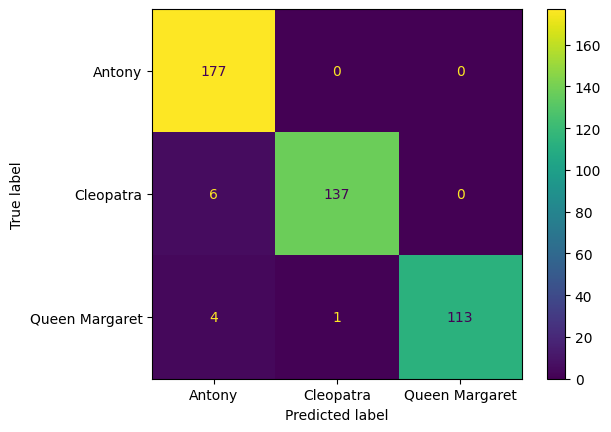

In [25]:
# Matriz de confusión y recall

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)

In [26]:
# TODO: Predecir para test y ver la matriz de confusión, y reportar accuracy

X_test_counts = count_vect_english_12.transform(X_test)
X_test_tfidf = tf_idf_true.transform(X_test_counts)
y_test_pred = bayes_clf.predict(X_test_tfidf)


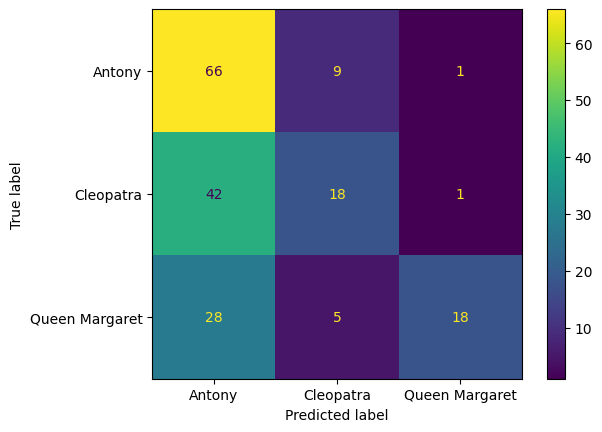

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

In [28]:
get_accuracy(y_test, y_test_pred)

0.5425531914893617

In [29]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_test_pred, average = None, labels = ['Antony', 'Cleopatra', 'Queen Margaret'])
recall = recall_score(y_test, y_test_pred, average = None, labels = ['Antony', 'Cleopatra', 'Queen Margaret'])

print('Precisión para Antony: ', precision[0].round(2))
print('Precisión para Cleopatra: ', precision[1].round(2))
print('Precisión para Queen Margaret: ', precision[2].round(2))
print('\n')
print('Recall para Antony: ', recall[0].round(2))
print('Recall para Cleopatra: ', recall[1].round(2))
print('Recall para Queen Margaret: ', recall[2].round(2))
print('\n')

Precisión para Antony:  0.49
Precisión para Cleopatra:  0.56
Precisión para Queen Margaret:  0.9


Recall para Antony:  0.87
Recall para Cleopatra:  0.3
Recall para Queen Margaret:  0.35




### Búsqueda de hiper-parámetros con Cross-Validation

acc=0.4182params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4364params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4312params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4587params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.5455params={'stop_words': 'english', 'ngram': (1, 1), 'idf': False}
acc=0.6000params={'stop_words': 'english', 'ngram': (1, 1), 'idf': False}
acc=0.5963params={'stop_words': 'english', 'ngram': (1, 1), 'idf': False}
acc=0.6055params={'stop_words': 'english', 'ngram': (1, 1), 'idf': False}
acc=0.4818params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4091params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4312params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4495params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.5545params={'stop_words': 'english', 'ngram': (1, 2), 'idf': False}
acc=0.5545params={'stop_words': 'english', 'ngram': (1, 2), 'idf': False}
acc=

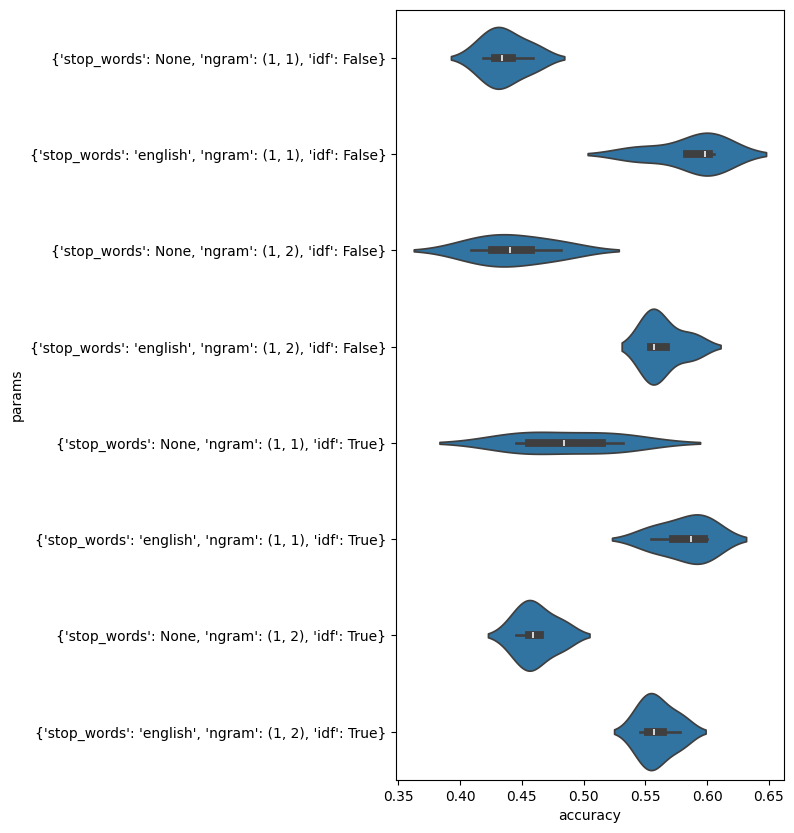

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# TODO: Agregar más variantes de parámetros que les parezcan relevantes
param_sets = [{"stop_words": None, "ngram": (1, 1), "idf": False},
              {"stop_words": 'english', "ngram": (1, 1), "idf": False},
              {"stop_words": None, "ngram": (1, 2), "idf": False},
              {"stop_words": 'english', "ngram": (1, 2), "idf": False},
              {"stop_words": None, "ngram": (1, 1), "idf": True},
              {"stop_words": 'english', "ngram": (1, 1), "idf": True},
              {"stop_words": None, "ngram": (1, 2), "idf": True},
              {"stop_words": 'english', "ngram": (1, 2), "idf": True}]

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Ahora usaremos train/validation/test
# Por lo tanto le renombramos train+validation = dev(elopment) dataset
X_dev = X_train
y_dev = y_train

## Para evitar errores
#del X_train
#del y_train

results = []

for params in param_sets:
    accuracies = []
    
    # Transormaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])
    
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):
        
        # Train y validation para el split actual
        X_train_ = X_dev[train_idxs]
        y_train_ = y_dev[train_idxs]
        X_val = X_dev[val_idxs]
        y_val = y_dev[val_idxs]
        
        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)
        
        # TODO: Completar el código para entrenar y evaluar 
        
        # Entrenamos con Train
        bayes_clf = MultinomialNB().fit(X_train_tf, y_train_)

        # Transformamos Validation
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)
        
        # Predecimos y evaluamos en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = get_accuracy(y_val, y_pred_val)
        accuracies.append(acc)
        print(f"{acc=:.4f}{params=}")

    # Store results for this parameter set
    results.append({"params": str(params), "accuracies": accuracies})

# Convert results to a DataFrame for plotting
data = []
for result in results:
    mean_acc = sum(result["accuracies"]) / len(result["accuracies"])
    std_acc = (sum((x - mean_acc) ** 2 for x in result["accuracies"]) / len(result["accuracies"])) ** 0.5
    for accuracy in result["accuracies"]:
        data.append({"params": result["params"], "accuracy": accuracy, "mean_acc": mean_acc, "std_acc": std_acc})

df = pd.DataFrame(data)

# Plotting the violin plot
plt.figure(figsize=(5, 10))
sns.violinplot(x="accuracy", y="params", data=df)
plt.xticks()
plt.show()

In [31]:
# Identificar el mejor conjunto de parámetros
best_params = max(results, key=lambda x: sum(x["accuracies"]) / len(x["accuracies"]))
print(f"Best parameters: {best_params['params']}")

Best parameters: {'stop_words': 'english', 'ngram': (1, 1), 'idf': False}


Final Accuracy: 0.5638
Confusion Matrix:
[[65  9  2]
 [39 20  2]
 [24  6 21]]
Classification Report:
                precision    recall  f1-score   support

        Antony       0.51      0.86      0.64        76
     Cleopatra       0.57      0.33      0.42        61
Queen Margaret       0.84      0.41      0.55        51

      accuracy                           0.56       188
     macro avg       0.64      0.53      0.54       188
  weighted avg       0.62      0.56      0.54       188



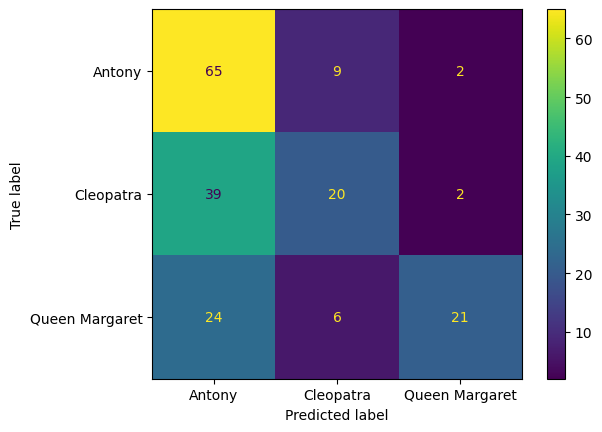

In [32]:
# Convertir los parámetros a formato dict
import ast
best_params_dict = ast.literal_eval(best_params["params"])

# Entrenar el modelo con el mejor conjunto de parámetros en todo el conjunto de entrenamiento
count_vect = CountVectorizer(stop_words=best_params_dict["stop_words"], ngram_range=best_params_dict["ngram"])
tf_idf = TfidfTransformer(use_idf=best_params_dict["idf"])

# Ajustar y transformar el conjunto de entrenamiento completo
X_train_counts = count_vect.fit_transform(X_train)
X_train_tf = tf_idf.fit_transform(X_train_counts)

# Entrenar el modelo
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Transformar el conjunto de prueba
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tf_idf.transform(X_test_counts)

# Predecir y evaluar en el conjunto de prueba
y_pred_test = bayes_clf.predict(X_test_tfidf)

# Calcular las métricas
accuracy = get_accuracy(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print(f"Final Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

Cross-validated SVM Accuracy: 0.5981 (±0.0267)

SVM Accuracy on Test Set: 0.5851
SVM Confusion Matrix:
[[56 17  3]
 [25 30  6]
 [18  9 24]]
SVM Classification Report:
                precision    recall  f1-score   support

        Antony       0.57      0.74      0.64        76
     Cleopatra       0.54      0.49      0.51        61
Queen Margaret       0.73      0.47      0.57        51

      accuracy                           0.59       188
     macro avg       0.61      0.57      0.57       188
  weighted avg       0.60      0.59      0.58       188



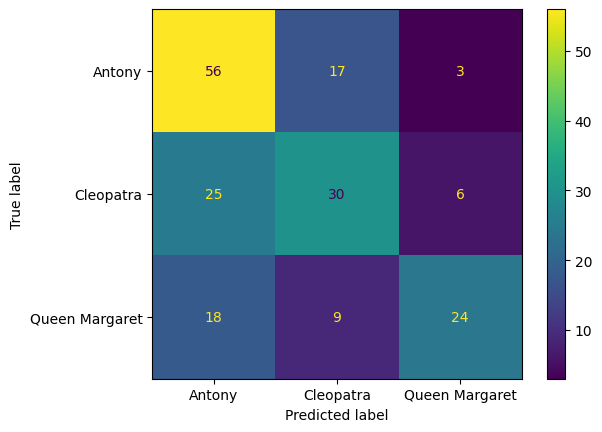

In [33]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definir el pipeline con CountVectorizer, TfidfTransformer y SVM con kernel lineal
svm_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(kernel='linear'))
])

# Entrenar y evaluar el modelo utilizando validación cruzada
svm_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=4)

print(f"Cross-validated SVM Accuracy: {svm_scores.mean():.4f} (±{svm_scores.std():.4f})")

# Entrenar el modelo final en todo el conjunto de entrenamiento
svm_pipeline.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred_svm = svm_pipeline.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_conf_matrix = confusion_matrix(y_test, y_pred_svm)
svm_class_report = classification_report(y_test, y_pred_svm)

print(f"\nSVM Accuracy on Test Set: {svm_accuracy:.4f}")

print("SVM Confusion Matrix:")
print(svm_conf_matrix)

print("SVM Classification Report:")
print(svm_class_report)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)